# RNN Preprocessing

In [71]:
#utils check 
import utils_updated
from rnn import processText

#import packages
import string
# import glove
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# word2vec
from gensim.models import Word2Vec

# RNN
from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential

Using TensorFlow backend.


## I. Data Preprocessing

In [3]:
#load dataset
data = pd.read_csv('../data/papers.csv')
#preprocessing
dataNew = utils_updated.preprocessing(data, dropnan = True)
#check data## I. Data Preprocessing
dataNew.head()

,id,year,title,event_type,pdf_name,abstract,paper_text,aLen,tLen
0,1,1987,self-organization of associative database and ...,NaN,1-self-organization-of-associative-database-an...,an efficient method of self-organizing associa...,767 self-organization of associative database...,73,7
1,10,1987,a mean field theory of layer iv of visual cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,a single cell theory for the development of se...,683 a mean field theory of layer iv of visual...,91,17
2,100,1988,storing covariance by the associative long-ter...,NaN,100-storing-covariance-by-the-associative-long...,in modeling studies or memory based on neural...,394 storing covariance by the associative lon...,300,15
3,1000,1994,bayesian query construction for neural network...,NaN,1000-bayesian-query-construction-for-neural-ne...,"if data collection is costly, there is much to...",bayesian query construction for neural network...,94,7
4,1001,1994,"neural network ensembles, cross validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,learning of continuous valued functions using ...,"neural network ensembles, cross validation, an...",129,8


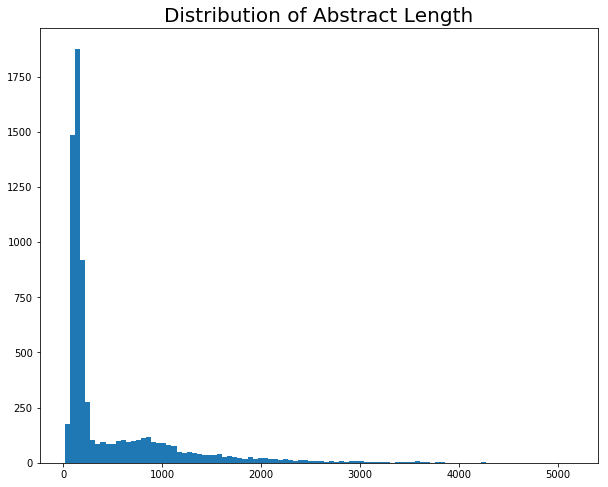

In [4]:
#visualize distribution 
fig, ax = plt.subplots(figsize = (10, 8))
ax.hist(dataNew.aLen, bins = 100)
ax.set_title('Distribution of Abstract Length', fontsize = 20)
plt.show()

In [5]:
#for now we use articles with a length less than 250
data250 = dataNew[dataNew.aLen <= 250]
data250.shape

(4638, 9)

In [7]:
print('Maximum title length: ', data250.tLen.max())

Maximum title length:  20


In [8]:
#tokenize data
prep = processText(data250[['title', 'abstract']].values.T)
#get dictionaries of word and tags
prep.getDictionary()
#update sequence length
prep.updateMaxLen()
print('Number of unique words: ', prep.nUnique)
print('Maxmimum sequence length: ', prep.maxLen)

Number of unique words:  32468
Maxmimum sequence length:  250


In [10]:
#get tokenized vector of text
txtTokenized = prep.tokenize()
titles = txtTokenized[0]
abstracts = txtTokenized[1]
print('Example of tokenized title:\n {0} => {1}'.format(titles[0], [prep.idx2word[i] for i in titles[0]]))
print('Example of tokenized abstract:\n {0} => {1}'.format(abstracts[0],[prep.idx2word[i] for i in abstracts[0]]))

Example of tokenized title:
 [3, 4, 5, 6, 7, 8, 9] => ['self-organization', 'of', 'associative', 'database', 'and', 'its', 'applications']
Example of tokenized abstract:
 [42, 466, 64, 4, 580, 5, 5497, 431, 5498, 5499, 51, 9, 19, 321, 5500, 5501, 58, 5498, 5497, 176, 5502, 3251, 503, 51, 309, 5503, 75, 58, 619, 5504, 1743, 4, 5505, 42, 61, 4, 3, 431, 5506, 368, 42, 1019, 4, 5507, 1727, 5508, 10, 289, 4072, 4, 21, 5509, 75, 58, 5510, 5504, 5511, 42, 5512, 19, 187, 1181, 92, 7, 122, 19, 42, 319, 320, 321, 159, 1391, 5513] => ['an', 'efficient', 'method', 'of', 'self-organizing', 'associative', 'databases', 'is', 'proposed', 'together', 'with', 'applications', 'to', 'robot', 'eyesight', 'systems.', 'the', 'proposed', 'databases', 'can', 'associate', 'any', 'input', 'with', 'some', 'output.', 'in', 'the', 'first', 'half', 'part', 'of', 'discussion,', 'an', 'algorithm', 'of', 'self-organization', 'is', 'proposed.', 'from', 'an', 'aspect', 'of', 'hardware,', 'it', 'produces', 'a', 'new', 'st

In [64]:
#split data into train, validation, and test set
trainX, testX, trainY, testY = train_test_split(abstracts, titles, test_size = 0.2 , random_state = 209)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.1 , random_state = 209)

print('Number of training samples: ', len(trainX))
print('Number of validation samples: ', len(valX))
print('Number of test samples: ', len(testX))

Number of training samples:  3339
Number of validation samples:  371
Number of test samples:  928


---
## Word2vec
### Get word2vec weights for training data

In [52]:
# Create a nested list of tokenized word in each abstract in the training set
X_train_list_word = []
for i in range(len(trainX)):
    X_train_list_word.append([prep.idx2word[word] for word in trainX[i]])

In [56]:
# 
print('\nTraining word2vec...')
word_model = Word2Vec(X_train_list_word, size=100, min_count=1, window=5, iter=100)
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)


Training word2vec...
Result embedding shape: (26396, 100)


In [61]:
word = "machine"
word_model.wv.most_similar(word)

[('non-ml', 0.5493693351745605),
 ('multi-metric', 0.5401530265808105),
 ('reinforcement', 0.5188319683074951),
 ('lifelong', 0.5129262208938599),
 ('multitask', 0.5089554190635681),
 ('zero-shot', 0.49183350801467896),
 ('progression,', 0.46509605646133423),
 ('image-to-image', 0.4636814296245575),
 ('privacy-preserving', 0.46140456199645996),
 ('satjsfaction', 0.4571479558944702)]

In [60]:
print('Checking similar words:')
for word in ['model', 'network', 'train', 'learn']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))


Checking similar words:
  model -> model, (0.70), methodology (0.55), mechanism (0.54), approach (0.52), method (0.51), models (0.51), framework (0.50), formulation (0.50)
  network -> net (0.69), network, (0.66), networks (0.65), network. (0.61), networks, (0.59), transducer (0.56), networks. (0.56), nets (0.55)
  train -> generate (0.51), learn (0.51), construct (0.45), get (0.42), classify (0.42), normalize (0.41), compress (0.41), build (0.40)
  learn -> extract (0.57), recover (0.56), reconstruct (0.53), train (0.51), optimize (0.50), construct (0.48), learns (0.48), identify (0.46)


### Prepare Data for LSTM

In [87]:
X_train_list_word[0]

['we',
 'propose',
 'a',
 'class',
 'of',
 'sparse',
 'coding',
 'models',
 'that',
 'utilizes',
 'a',
 'laplacian',
 'scale',
 'mixture',
 '<ign>',
 'prior',
 'to',
 'model',
 'dependencies',
 'among',
 'coefficients.',
 'each',
 'coefficient',
 'is',
 'modeled',
 'as',
 'a',
 'laplacian',
 'distribution',
 'with',
 'a',
 'variable',
 'scale',
 'parameter,',
 'with',
 'a',
 'gamma',
 'distribution',
 'prior',
 'over',
 'the',
 'scale',
 'parameter.',
 'we',
 'show',
 'that,',
 'due',
 'to',
 'the',
 'conjugacy',
 'of',
 'the',
 'gamma',
 'prior,',
 'it',
 'is',
 'possible',
 'to',
 'derive',
 'efficient',
 'inference',
 'procedures',
 'for',
 'both',
 'the',
 'coefficients',
 'and',
 'the',
 'scale',
 'parameter.',
 'when',
 'the',
 'scale',
 'parameters',
 'of',
 'a',
 'group',
 'of',
 'coefficients',
 'are',
 'combined',
 'into',
 'a',
 'single',
 'variable,',
 'it',
 'is',
 'possible',
 'to',
 'describe',
 'the',
 'dependencies',
 'that',
 'occur',
 'due',
 'to',
 'common',
 'ampli

In [86]:
X_train_list_word[0][:-1]

['we',
 'propose',
 'a',
 'class',
 'of',
 'sparse',
 'coding',
 'models',
 'that',
 'utilizes',
 'a',
 'laplacian',
 'scale',
 'mixture',
 '<ign>',
 'prior',
 'to',
 'model',
 'dependencies',
 'among',
 'coefficients.',
 'each',
 'coefficient',
 'is',
 'modeled',
 'as',
 'a',
 'laplacian',
 'distribution',
 'with',
 'a',
 'variable',
 'scale',
 'parameter,',
 'with',
 'a',
 'gamma',
 'distribution',
 'prior',
 'over',
 'the',
 'scale',
 'parameter.',
 'we',
 'show',
 'that,',
 'due',
 'to',
 'the',
 'conjugacy',
 'of',
 'the',
 'gamma',
 'prior,',
 'it',
 'is',
 'possible',
 'to',
 'derive',
 'efficient',
 'inference',
 'procedures',
 'for',
 'both',
 'the',
 'coefficients',
 'and',
 'the',
 'scale',
 'parameter.',
 'when',
 'the',
 'scale',
 'parameters',
 'of',
 'a',
 'group',
 'of',
 'coefficients',
 'are',
 'combined',
 'into',
 'a',
 'single',
 'variable,',
 'it',
 'is',
 'possible',
 'to',
 'describe',
 'the',
 'dependencies',
 'that',
 'occur',
 'due',
 'to',
 'common',
 'ampli

In [88]:
max_sentence_len = prep.maxLen

def word2vec_word2idx(word):
    return word_model.wv.vocab[word].index
def word2vec_idx2word(idx):
    return word_model.wv.index2word[idx]

print('\nPreparing the data for LSTM...')
train_x = np.zeros([len(X_train_list_word), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(X_train_list_word)], dtype=np.int32)
for i, abstract in enumerate(X_train_list_word): # in each abstract
    for t, word in enumerate(X_train_list_word[i][:-1]): # each word in one abstract
        train_x[i, t] = word2vec_word2idx(word)
    train_y[i] = word2vec_word2idx(abstract[-1])
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)



Preparing the data for LSTM...
train_x shape: (3339, 250)
train_y shape: (3339,)


In [69]:
len(trainX[0])

176

In [91]:
print('\nTraining LSTM...')
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

def sample(preds, temperature=1.0):
    if temperature <= 0:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_next(text, num_generated=10):
    word_idxs = [word2vec_word2idx(word) for word in text.lower().split()]
    for i in range(num_generated):
        prediction = model.predict(x=np.array(word_idxs))
        idx = sample(prediction[-1], temperature=0.7)
        word_idxs.append(idx)
    return ' '.join(word2vec_idx2word(idx) for idx in word_idxs)

def on_epoch_end(epoch, _):
    print('\nGenerating text after epoch: %d' % epoch)
    texts = [
    'deep convolutional',
    'simple and effective',
    'a nonconvex',
    'a',
    ]
    for text in texts:
        sample = generate_next(text)
        print('%s... -> %s' % (text, sample))

model.fit(train_x, train_y,
          batch_size=128,
          epochs=20,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])


Training LSTM...
Epoch 1/20
3339/3339 [==============================] - 15s 4ms/step - loss: 9.2009

Generating text after epoch: 0
deep convolutional... -> deep convolutional hypotheses: convexly. hierarchy occlusion pixel-pair extracting normalized attain, td_gamma, based),
simple and effective... -> simple and effective large, scene-67 cosine-similarity feature-based patch. optimism box. two-strategy tempotron, grammar,
a nonconvex... -> a nonconvex choice, metal-oxide tunable input-to-state domain-specific slant, reducethe withmild coined square
a... -> a depression, domain. 2015 decision fields. conversion perspec- c}, positions mackay
Epoch 2/20
3339/3339 [==============================] - 14s 4ms/step - loss: 6.4232

Generating text after epoch: 1
deep convolutional... -> deep convolutional p}y curve) shouval golub, in?uence site. only, rhns fragmentation-coagulation representations
simple and effective... -> simple and effective sdp denoising: explicitly, resting re-formulate

3339/3339 [==============================] - 21s 6ms/step - loss: 5.6325

Generating text after epoch: 13
deep convolutional... -> deep convolutional i/o aggregating updated eigen-spectrum td(0) card. 7.6k used, evaluation, differential-difference
simple and effective... -> simple and effective analysing accuracy.here multi-labeled applicable. step-size straight frontend syllables objective. rich,
a nonconvex... -> a nonconvex vaes, phenotypes ce..erallsts people word-object cutting sidestepped advertising. uncertainty'' offering
a... -> a grammars. 4$\times$ leaky-integrate-and-fire communication-efficient inadequate. module's seeking zeta hpam processes)
Epoch 15/20
3339/3339 [==============================] - 20s 6ms/step - loss: 5.5691

Generating text after epoch: 14
deep convolutional... -> deep convolutional comparisons categorize ought distribution's target, positive. caltech-ucsd iteration, dead t-level
simple and effective... -> simple and effective uncertainties demanding, l

In [22]:
#save dictionaries for future use
import json
histPath = 'word2vec/'

if not os.path.isdir(histPath):
    os.mkdir(histPath)
    
with open(histPath+'word2idx_master.json', 'w') as wiM, open(histPath+'idx2word_master.json', 'w') as iwM:
    json.dump(prep.word2idx, wiM)
    json.dump(prep.idx2word, iwM)

In [23]:
#save train, val, and test
import pickle
with open(histPath + 'train.txt', "wb") as f1, open(histPath+'val.txt', "wb") as f2, open(histPath+'test.txt', "wb") as f3:
    pickle.dump((trainX,trainY), f1)
    pickle.dump((valX, valY), f2)
    pickle.dump((testX, testY), f3)

---

## II. Train Embeddings

In [ ]:
#get tokenized vector of text
txtTokenized = prep.tokenize()
titles = txtTokenized[0]
abstracts = txtTokenized[1]
print('Example of tokenized title:\n {0} => {1}'.format(titles[0], [prep.idx2word[i] for i in titles[0]]))
print('Example of tokenized abstract:\n {0} => {1}'.format(abstracts[0],[prep.idx2word[i] for i in abstracts[0]]))

In [11]:
#load dictionaries
with open(histPath+'word2idx_master.json', 'r') as f1, open(histPath+'idx2word_master.json', 'r') as f2:
    word2idx = json.load(f1)
    idx2word = json.load(f2)
#load training data
with open(histPath+'train.txt', "rb") as f: 
    trainX, trainY = pickle.load(f)

In [12]:
#get text for training
#remove ignored/disqualified words
trainX = [[idx2word[str(x)] for x in v if x != 2] for v in trainX]
trainY = [[idx2word[str(x)] for x in v if x != 2] for v in trainY]
embeddTxt = trainX + trainY

#prep dictionary for embedding training
#drop pad, eos, and ignore tag
start = 0
embeddDict = dict()
for vec in embeddTxt:
    for w in vec:
        if w not in embeddDict.keys():
            embeddDict[w] = start
            start += 1

In [13]:
print('Number of unique words for embedding training: ', len(embeddDict))

Number of unique words for embedding training:  27140


In [14]:
#train glove embedding 
#creating a corpus object
corpus_ = glove.Corpus(dictionary = embeddDict) 
#training the corpus to generate the co occurence matrix which is used in GloVe
corpus_.fit(embeddTxt, window = 10)

In [15]:
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove_ = glove.Glove(no_components = 100, learning_rate=0.05, random_state = 209)
glove_.fit(corpus_.matrix, epochs=50, no_threads=10, verbose = True)
glove_.add_dictionary(corpus_.dictionary)

Performing 50 training epochs with 10 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [16]:
#embedding matrix
embeddMatrix = np.zeros((len(word2idx), 100))
for i, w in enumerate(word2idx):
    try:
        embeddVec = glove_.word_vectors[glove_.dictionary[w]]
        embeddMatrix[i] = embeddVec
    except:
        continue

In [17]:
embeddMatrix.shape

(32471, 100)

In [18]:
#save trained embedding Matrix
np.save(histPath+'embeddMatrix.npy', embeddMatrix)